In [1]:
#-------- Import Libraries --------#

import torch
import time
import os
import sys
import random
import pickle
import mlflow
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net, Net_thesis, Net_project
import functions as func

In [3]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [4]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [5]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net_project
import functions as func


In [6]:
#-------- Import Dataset --------#

data_list = []
target_list = []

import glob
for i in range(4):
    i = i+1
    print(i)
    for fp in glob.glob("../data/train/*{}*input.npz".format(i)):
        print(fp)
        data = np.load(fp)["arr_0"]
        targets = np.load(fp.replace("input", "labels"))["arr_0"]
        data_list.append(data)
        target_list.append(targets)

for fp in glob.glob("../data/validation/*5*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
data_partitions = len(data_list)

print("\nNumber of files:", data_partitions)

for i in range(data_partitions):
    print("Size of file", i, len(data_list[i]))

1
../data/train/P1_input.npz


2
../data/train/P2_input.npz


3
../data/train/P3_input.npz


4
../data/train/P4_input.npz



Number of files: 5
Size of file 0 1526
Size of file 1 1168
Size of file 2 1480
Size of file 3 1532
Size of file 4 1207


In [7]:
#-------- Select the network you would like to use -------#

CNN = False # ONLY CNN
CNN_RNN = True # CNN + RNN

# Hyperparameters to fine-tune
embedding = "esm_ASM"
numHN=32
numFilter=100
dropOutRate=0.1
learning_rate=0.001
weight_decay = 0.0001

#for ml-flow
name_experiment = "hyperparameter grid"


##--- parameters fixed
keep_energy=True
cross_validation = False
bat_size = 128
num_classes=1
epochs = 100
patience=10
criterion = nn.BCEWithLogitsLoss()

In [8]:
# Parameters
embedding = "esm-1b"
numHN = 26
numFilter = 200
dropOutRate = 0.1
keep_energy = True
learning_rate = 0.001
weight_decay = 0.0001
name_experiment = "hyperparameter grid"


In [9]:
#embedding of data

#create directory to fetch/store embedded
embedding_dir= '../data/embeddedFiles/'
try:
    os.mkdir(embedding_dir)
except:
    pass


#try to fecth if already exist
if embedding == "Baseline":   
    data_list_enc = data_list
else:
    try:
        infile = open(embedding_dir+'dataset-{}'.format(embedding), 'rb')
        data_list_enc =  pickle.load(infile)
        infile.close()

    #if no prior file, use encoder script to encode:
    except:
        print("embedded file not found")
        sys.exit()

In [10]:
print(len(data_list_enc))
print(len(data_list_enc[0]))
print(len(data_list_enc[0][0]))
print(len(data_list_enc[0][0][0]))


5
1526
420
1280


In [11]:
# Add energy terms from original dataset         
if keep_energy:
    if embedding == "Baseline":
        energy_set =''
        pad = 0
        pass
    else:
        for i in range (len(data_list_enc)):
            energy_set = func.extract_energy_terms(data_list[i]) 
            for j in range(0, len(energy_set)):
                pad = 420 - len(energy_set[j])
                energy_set[j] = np.pad(energy_set[j], ((0, pad), (0, 0)), 'constant')
                data_list_enc[i][j] = np.concatenate((data_list_enc[i][j], energy_set[j]), axis=1)

                
        

In [12]:
print(len(data_list_enc))
print(len(data_list_enc[0]))
print(len(data_list_enc[0][0]))
print(len(data_list_enc[0][0][0]))

5
1526
420
1314


In [13]:
import gc
del data_list, energy_set, pad
gc.collect()

84

In [14]:
X_train = np.concatenate(data_list_enc[0:3])
y_train = np.concatenate(target_list[0:3])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_valid = np.concatenate(data_list_enc[3:4])
y_valid = np.concatenate(target_list[3:4])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples,nx,ny)


X_test = np.concatenate(data_list_enc[4:])
y_test = np.concatenate(target_list[4:])
nsamples, nx, ny = X_test.shape
print("Test set shape:", nsamples,nx,ny)

# features and residues
features = list(range(ny))
residues = list(range(nx)) 
n_features = len(features)
input_size = len(residues)

del data_list_enc
gc.collect()

# Dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
val_ds = []
for i in range(len(X_valid)):
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i][:,features]), y_test[i]])
    
    
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=len(test_ds), shuffle=True)


del X_train, X_test, y_train, y_test 
gc.collect()

Training set shape: 4174 420 1314


Validation set shape: 1532 420 1314


Test set shape: 1207 420 1314


0

In [15]:

###############################
###    CNN+RNN (thesis)     ###
###############################
start = time.time()

if cross_validation == False:
    
    print("Parameters:")
    print("cross_validation", cross_validation)
    print("embedding", embedding)
    print("numHN", numHN)
    print("numFilter", numFilter)
    print("dropOutRate", dropOutRate)
    print("keep_energy", keep_energy)
    print("num_classes", num_classes)
    print("learning_rate", learning_rate)
    print("bat_size", bat_size)
    print("patience", patience)
    print("criterion", criterion)
    print("\n\n")
    
    #-------- Train --------#

    # Initialize network
    net = Net_project(num_classes=num_classes, 
             n_features=n_features, 
             numHN=numHN, 
             numFilter=numFilter,
             dropOutRate=dropOutRate).to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=weight_decay,
                           amsgrad=True,)
    
    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs, test_preds, test_targs, test_loss, test_acc, test_auc = func.train_project(net, optimizer, train_ldr, val_ldr, test_ldr, X_valid, epochs, criterion, patience)

else:
    pass

print("Done in", round((time.time()-start)/60,2), "mins." )

print("test_loss, test_acc, test_auc:")
print(test_loss.item(), ",", test_acc[0], ",", test_auc[0])




Parameters:
cross_validation False
embedding esm-1b
numHN 26
numFilter 200
dropOutRate 0.1
keep_energy True
num_classes 1
learning_rate 0.001
bat_size 128
patience 10
criterion BCEWithLogitsLoss()





Epoch 0  	 Train loss: 0.00423 	 Validation loss: 0.00393


Epoch 5  	 Train loss: 0.00254 	 Validation loss: 0.00275


Epoch 10  	 Train loss: 0.00212 	 Validation loss: 0.00251


Epoch 15  	 Train loss: 0.00181 	 Validation loss: 0.00251


Early stopping



0


Done in 10.15 mins.
test_loss, test_acc, test_auc:
0.38305628299713135 , 0.8566694283347142 , 0.7736335100804529


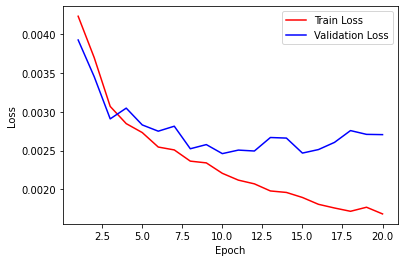

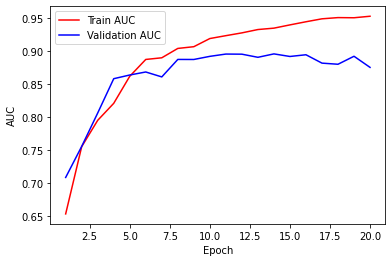

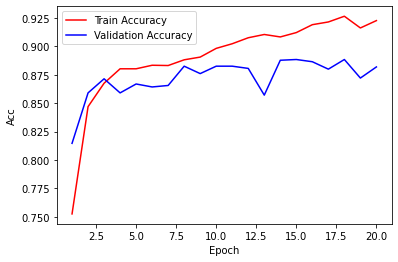

AUC:  0.7736335100804529
MCC:  0.5951086415911974


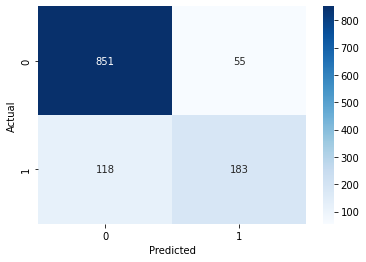

AUC: 0.774
173


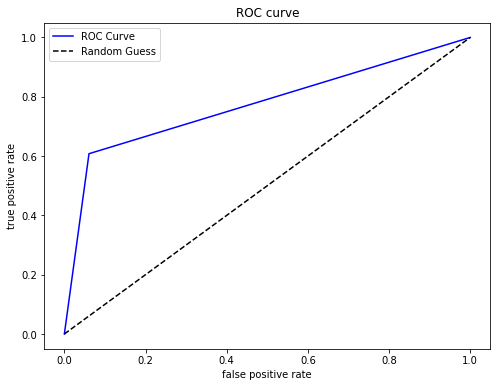

AUC:  0.7736335100804529
MCC:  0.5951086415911974
ACC:  0.8566694283347142


In [16]:
#-------- Performance --------#

epoch = np.arange(1,len(train_losses)+1)
plt.figure()
plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_auc)+1)
plt.figure()
plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
plt.legend(['Train AUC','Validation AUC'])
plt.xlabel('Epoch'), plt.ylabel('AUC')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')
plt.show()


#-------- Save results --------#

results = pd.DataFrame(list(zip( (int(x) for x in test_targs), (int(x) for x in test_preds))),columns =['target', 'pred'])

#print(results)
results.to_csv('../results/targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_energ_{}.csv'.format(embedding,numHN,numFilter,int(dropOutRate*10), keep_energy), index=False)


#-------- Performance Evaluation --------#
# The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

print("AUC: ", roc_auc_score(results['target'], results['pred']))
print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

# Plot roc curve

fpr, tpr, thres = roc_curve(results['target'], results['pred'])
print('AUC: {:.3f}'.format(roc_auc_score(results['target'], results['pred'])))

print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))

plt.figure(figsize=(8,6))

# roc curve
plt.plot(fpr, tpr, "b", label='ROC Curve')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")

try:
    mkdir('results/plots/')
except:
    pass

plt.savefig('../results/plots/targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_energ_{}_ROC.png'.format(embedding,numHN,numFilter,int(dropOutRate*10), keep_energy))
plt.show()

AUC = roc_auc_score(results['target'], results['pred'])
MCC = matthews_corrcoef(results['target'], results['pred'])
ACC = accuracy_score(results['target'], results['pred'])
print("AUC: ", AUC)
print("MCC: ", MCC)
print("ACC: ", ACC)

In [17]:
#storing values
import mlflow
import mlflow.sklearn

exp = mlflow.set_experiment(name_experiment)
experiment = mlflow.get_experiment(exp.experiment_id)

print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

with mlflow.start_run():
    mlflow.log_param('embedding', embedding) 
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_param('learning rate', learning_rate)
    mlflow.log_param('Weight decay', weight_decay)
    mlflow.log_metric('test AUC', AUC)
    mlflow.log_metric('test MCC', MCC)
    mlflow.log_metric('test ACC', ACC)
    
    mlflow.log_metric('train ACC', train_acc[-1])
    mlflow.log_metric('train AUC', train_auc[-1])
    mlflow.log_metric('valid ACC', valid_acc[-1])
    mlflow.log_metric('valid AUC', valid_auc[-1])


Name: hyperparameter grid
Experiment_id: 1
Artifact Location: file:///home/shannara/DL_02456/dayana_run/scripts/mlruns/1
